## Settings for Google Colab

Please uncomment and run cell below if your are on Colab to set data and auxiliary files.

In [1]:
# %%capture
# !mkdir data
# !wget https://raw.githubusercontent.com/datacubeR/DeepAnt/master/data/TravelTime_451.csv -O data/TravelTime_451.csv
# !wget https://raw.githubusercontent.com/datacubeR/DeepAnt/master/data/DeepAnt.png -O data/DeepAnt.png
# !wget https://raw.githubusercontent.com/datacubeR/DeepAnt/master/deepant.py -O deepant.py
# !wget https://raw.githubusercontent.com/datacubeR/DeepAnt/master/utils.py -O utils.py
# !pip install pytorch-lightning
# !pip install torchinfo

## DeepAnt

In [58]:
import pandas as pd
import pytorch_lightning as pl
import numpy as np
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from torchinfo import summary
from math import floor

from scipy.signal import periodogram

from deepant import AnomalyDetector, DataModule, TrafficDataset, DeepAnt

from utils import plot_predictions, loss_plot, ts_plot

pl.seed_everything(42, workers=True)
import matplotlib.pyplot as plt

if not torch.cuda.is_available():
    print('Please Activate GPU Accelerator if available')
else:
    print('Everything is Set')


Global seed set to 42


Please Activate GPU Accelerator if available


## Data Import

In order to implement DeepAnt I will use a dataset that is part of Numenta Benchmark that is used in the Paper as part of Model Validation. The dataset can be found in the same Repo. According to the name, the dataset contains Traveltime as a timeseries. 

The task is to find out what scores are anomaly.

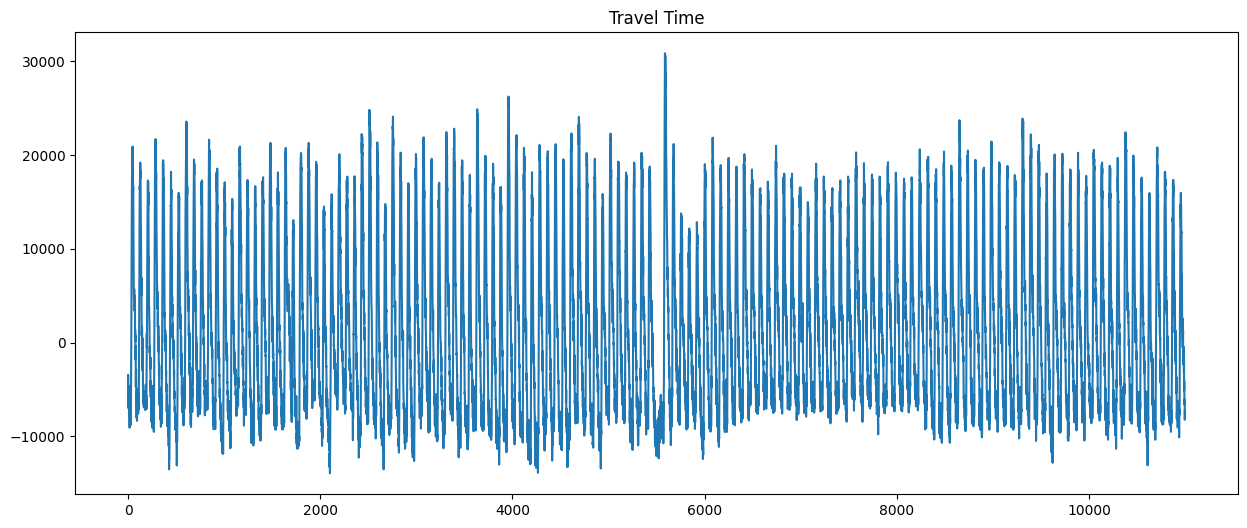

In [2]:
#df = pd.read_csv('data/TravelTime_451.csv', index_col = 'timestamp', parse_dates=['timestamp'])
df_1 = np.genfromtxt('/Users/Okano700/Documents/GitHub/metaFeaturesTS/data/UCR_Anomaly_FullData/094_UCR_Anomaly_NOISEBIDMC1_2500_5400_5600.txt')
df = pd.DataFrame(df_1,columns=['value'])
df.plot(figsize = (15, 6), title = 'Travel Time', legend = False);
#plt.plot()

In [4]:
df

,value
0,-4212.7637
1,-3438.2873
2,-4704.5428
3,-6975.8217
4,-6304.1302
...,...
10995,-6604.4306
10996,-6067.5663
10997,-6577.1845
10998,-8221.0213


In [3]:
f, px = periodogram(np.array(df)[:,0], detrend='linear')
floor(1/f[np.argmax(px)] + 0.5)

82

In [4]:
n = 20
ind = np.argpartition(px, -n)[-n:]


print([floor(1/f[a] + 0.5) for a in px.argsort()[-n:][::-1]])
print([f[a] for a in px.argsort()[-n:][::-1]])

[82, 83, 81, 80, 80, 79, 81, 41, 41, 41, 83, 40, 40, 40, 41, 40, 27, 42, 85, 79]
[0.01218181818181818, 0.01209090909090909, 0.012363636363636363, 0.012454545454545454, 0.012545454545454545, 0.012636363636363635, 0.012272727272727272, 0.024454545454545455, 0.024272727272727272, 0.02418181818181818, 0.011999999999999999, 0.02509090909090909, 0.024999999999999998, 0.02518181818181818, 0.024636363636363633, 0.02490909090909091, 0.03654545454545454, 0.02409090909090909, 0.011818181818181818, 0.012727272727272726]


In [7]:
plt.figure()
plt.semilogy((1/f), px)
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.show()

NameError: name 'plt' is not defined

## Model Training

In order to make the algorithm to work I will use Hyperparameters mentioned in the paper as much as possible. In case no values are provided, I will be hard coding those.

![](data/DeepAnt.png)

In this case, I will be using Sequence Length of 10, and Forecasting Horizon (P_w) 1. The Convolution Blocks use 32 filters, 3x3 Conv Kernel and 2x2 MaxPooling. Fully Connected Layer uses a 40 Units Hidden Layer before Ouptut.

The Model is Trained with MAE Loss (L1Loss in Pytorch) during 30 epochs.



In [24]:
SEQ_LEN = 82*2
dataset = TrafficDataset(df, SEQ_LEN)
target_idx = dataset.timestamp # Timestamps to detect where the Anomaly Happens
X, y = dataset[0]
X.shape, y.shape, len(dataset) # Checking Sizes are compatible...


(torch.Size([1, 164]), torch.Size([1]), 10836)

In [6]:
model = DeepAnt(SEQ_LEN, 1)
sample = torch.randn(32,1,SEQ_LEN)

model(sample).shape

torch.Size([32, 1])

In [7]:
model = DeepAnt(SEQ_LEN, 1)
anomaly_detector = AnomalyDetector(model)
dm = DataModule(df, SEQ_LEN)
mc = ModelCheckpoint(
    dirpath = 'checkpoints1',
    save_last = True,
    save_top_k = 1,
    verbose = True,
    monitor = 'train_loss', 
    mode = 'min'
    )

mc.CHECKPOINT_NAME_LAST = f'DeepAnt-best-checkpoint'
summary(model)

Layer (type:depth-idx)                   Param #
DeepAnt                                  --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       128
│    └─ReLU: 2-2                         --
│    └─MaxPool1d: 2-3                    --
├─Sequential: 1-2                        --
│    └─Conv1d: 2-4                       3,104
│    └─ReLU: 2-5                         --
│    └─MaxPool1d: 2-6                    --
├─Flatten: 1-3                           --
├─Sequential: 1-4                        --
│    └─Linear: 2-7                       49,960
│    └─ReLU: 2-8                         --
│    └─Dropout: 2-9                      --
├─Linear: 1-5                            41
Total params: 53,233
Trainable params: 53,233
Non-trainable params: 0

In [8]:
trainer = pl.Trainer(max_epochs=10,
                    accelerator="auto",
                    devices=1, 
                    callbacks=[mc], 
                    #progress_bar_refresh_rate=30, 
                    #fast_dev_run=True,
                    #overfit_batches=1
                    )
trainer.fit(anomaly_detector, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/Okano700/Documents/GitHub/DeepAntEmerson/lightning_logs

  | Name      | Type    | Params
--------------------------------------
0 | model     | DeepAnt | 53.2 K
1 | criterion | L1Loss  | 0     
--------------------------------------
53.2 K    Trainable params
0         Non-trainable params
53.2 K    Total params
0.213     Total estimated model params size (MB)


Epoch 0: 100%|█| 339/339 [00:27<00:00, 12.46it/s, loss=0.177, v_num=0, train_los

Epoch 0, global step 339: 'train_loss' reached 0.14050 (best 0.14050), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/checkpoints1/epoch=0-step=339.ckpt' as top 1


Epoch 1: 100%|█| 339/339 [01:10<00:00,  4.81it/s, loss=0.122, v_num=0, train_los

Epoch 1, global step 678: 'train_loss' reached 0.10703 (best 0.10703), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/checkpoints1/epoch=1-step=678.ckpt' as top 1


Epoch 2: 100%|█| 339/339 [01:10<00:00,  4.84it/s, loss=0.105, v_num=0, train_los

Epoch 2, global step 1017: 'train_loss' reached 0.09916 (best 0.09916), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/checkpoints1/epoch=2-step=1017.ckpt' as top 1


Epoch 3: 100%|█| 339/339 [01:09<00:00,  4.84it/s, loss=0.0922, v_num=0, train_lo

Epoch 3, global step 1356: 'train_loss' reached 0.06956 (best 0.06956), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/checkpoints1/epoch=3-step=1356.ckpt' as top 1


Epoch 4: 100%|█| 339/339 [01:11<00:00,  4.76it/s, loss=0.0863, v_num=0, train_lo

Epoch 4, global step 1695: 'train_loss' was not in top 1


Epoch 5: 100%|█| 339/339 [01:05<00:00,  5.14it/s, loss=0.0836, v_num=0, train_lo

Epoch 5, global step 2034: 'train_loss' reached 0.06122 (best 0.06122), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/checkpoints1/epoch=5-step=2034.ckpt' as top 1


Epoch 6: 100%|█| 339/339 [01:04<00:00,  5.25it/s, loss=0.0807, v_num=0, train_lo

Epoch 6, global step 2373: 'train_loss' was not in top 1


Epoch 7: 100%|█| 339/339 [01:06<00:00,  5.13it/s, loss=0.0726, v_num=0, train_lo

Epoch 7, global step 2712: 'train_loss' reached 0.05857 (best 0.05857), saving model to '/Users/Okano700/Documents/GitHub/DeepAntEmerson/checkpoints1/epoch=7-step=2712.ckpt' as top 1


Epoch 8: 100%|█| 339/339 [01:06<00:00,  5.12it/s, loss=0.0753, v_num=0, train_lo

Epoch 8, global step 3051: 'train_loss' was not in top 1


Epoch 9: 100%|█| 339/339 [01:08<00:00,  4.98it/s, loss=0.0722, v_num=0, train_lo

Epoch 9, global step 3390: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|█| 339/339 [01:08<00:00,  4.98it/s, loss=0.0722, v_num=0, train_lo


In [9]:
anomaly_detector = AnomalyDetector.load_from_checkpoint('checkpoints1/DeepAnt-best-checkpoint.ckpt',model = model)

In [10]:
output = trainer.predict(anomaly_detector, dm)
preds_losses = pd.Series(torch.tensor([item[1] for item in output]).numpy(), index = target_idx)

Predicting DataLoader 0: 100%|███████████| 10836/10836 [01:27<00:00, 124.34it/s]


# Finding Threshold

After checking the Loss Distribution, the Threshold chose for detecting anomaly wat set to 0.5

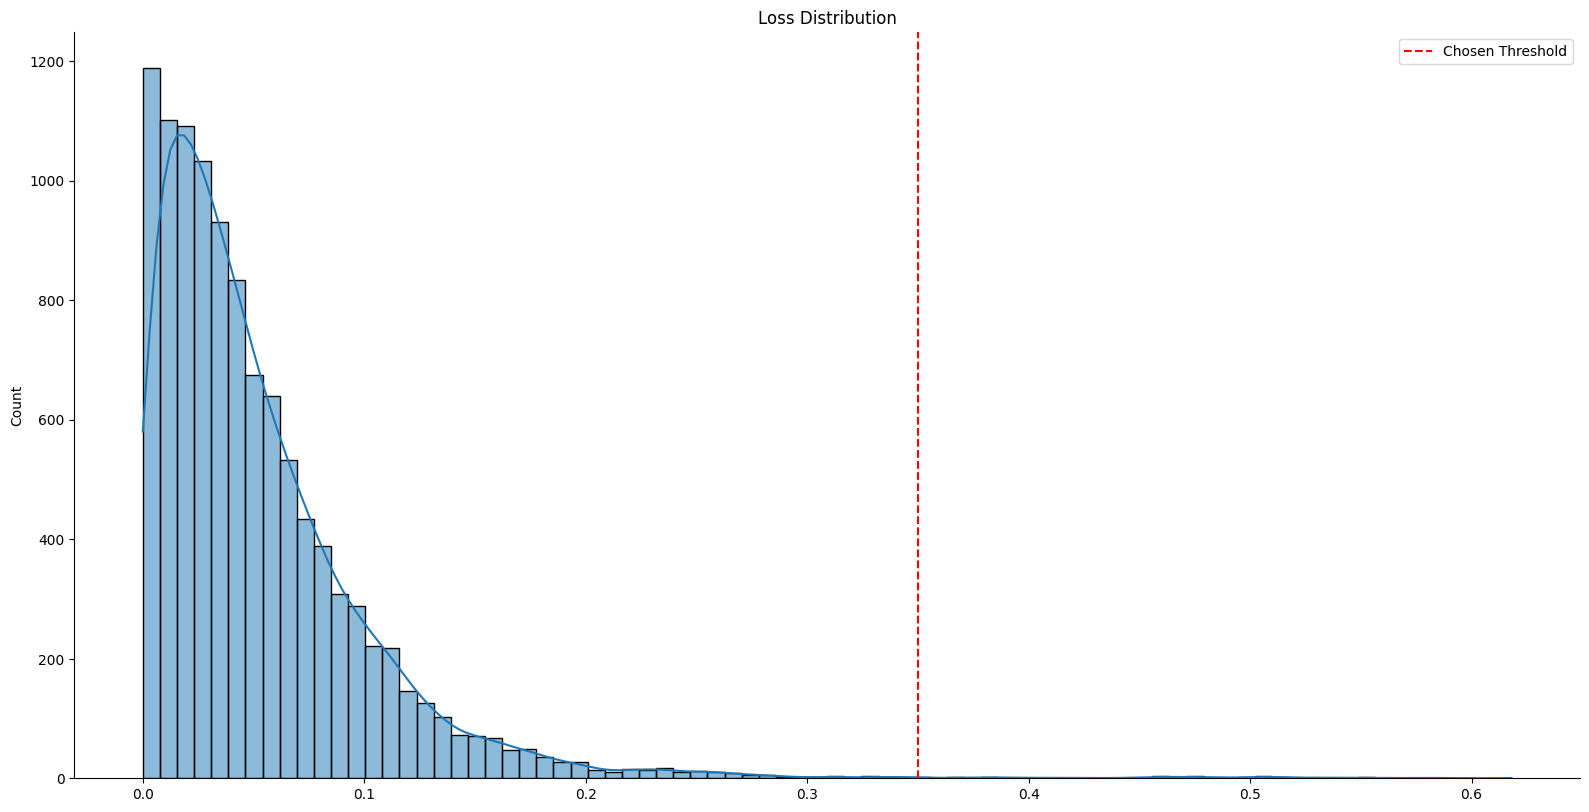

In [15]:
THRESHOLD = 0.35
plot_predictions(preds_losses, THRESHOLD)

## Detected Anomalies

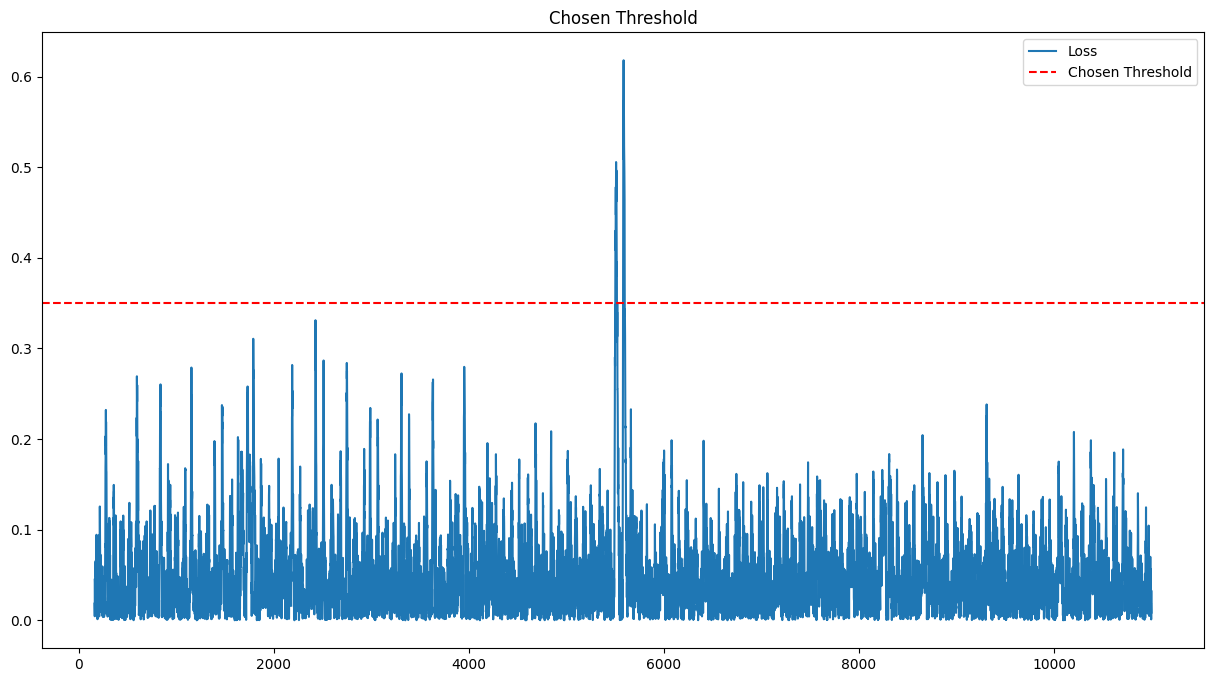

Anomalies Detected: 


5503    0.384997
5504    0.415312
5505    0.429940
5506    0.408534
5507    0.452392
5508    0.478090
5509    0.447447
5510    0.483090
5511    0.505718
5512    0.461848
5513    0.477170
5514    0.496443
5515    0.460953
5516    0.462389
5517    0.388126
5518    0.380697
5519    0.394856
5582    0.366991
5583    0.478320
5584    0.507716
5585    0.536847
5586    0.555353
5587    0.584204
5588    0.618045
5589    0.549174
5590    0.508571
5591    0.573804
5592    0.531919
5593    0.523265
5594    0.513650
5595    0.510542
5596    0.494927
5597    0.467418
5598    0.464021
5599    0.370646
dtype: float32

In [16]:
loss_plot(preds_losses, THRESHOLD)

print('Anomalies Detected: ')
preds_losses.loc[lambda x: x > THRESHOLD]

## Showing Anomalies in Context

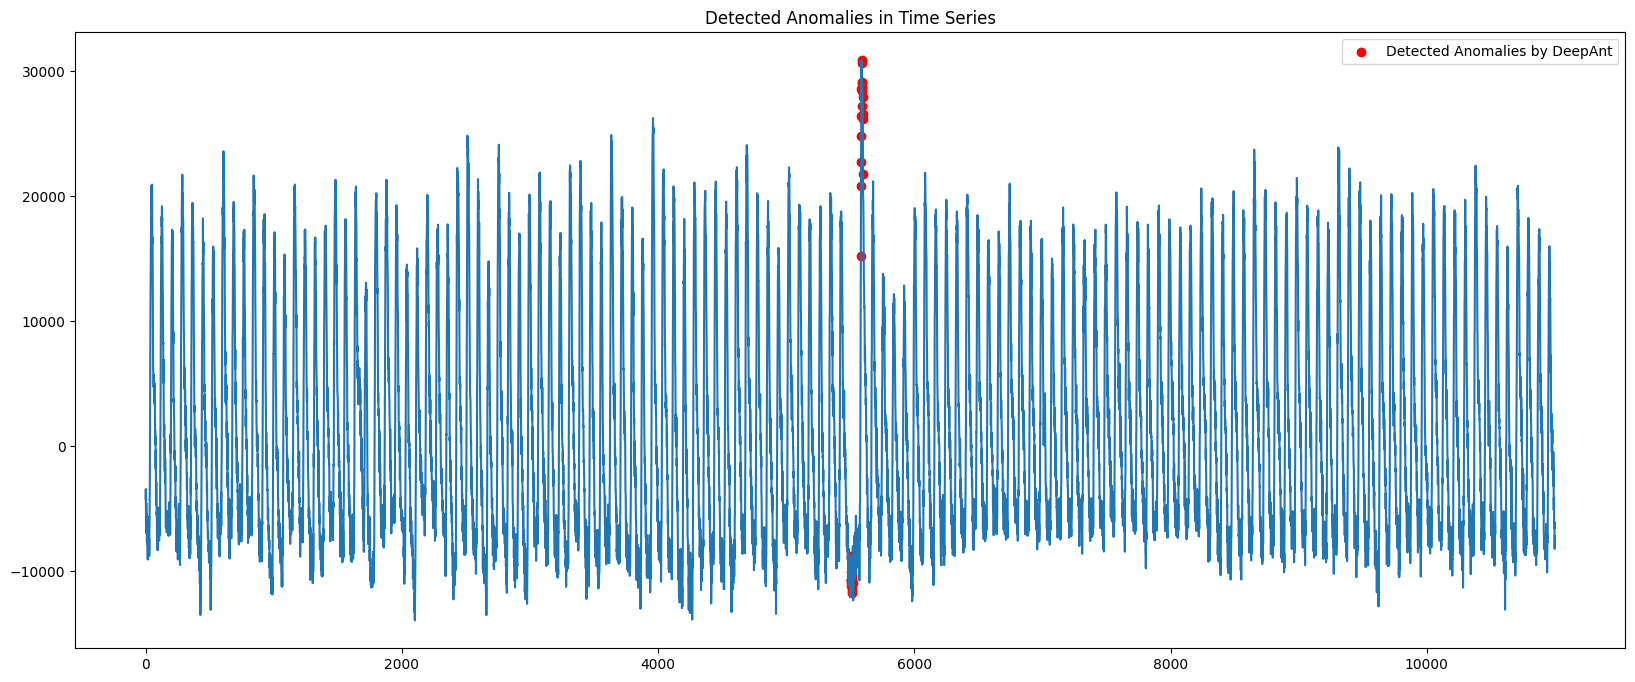

In [17]:
ts_plot(df, preds_losses, THRESHOLD)

## Looking Closer

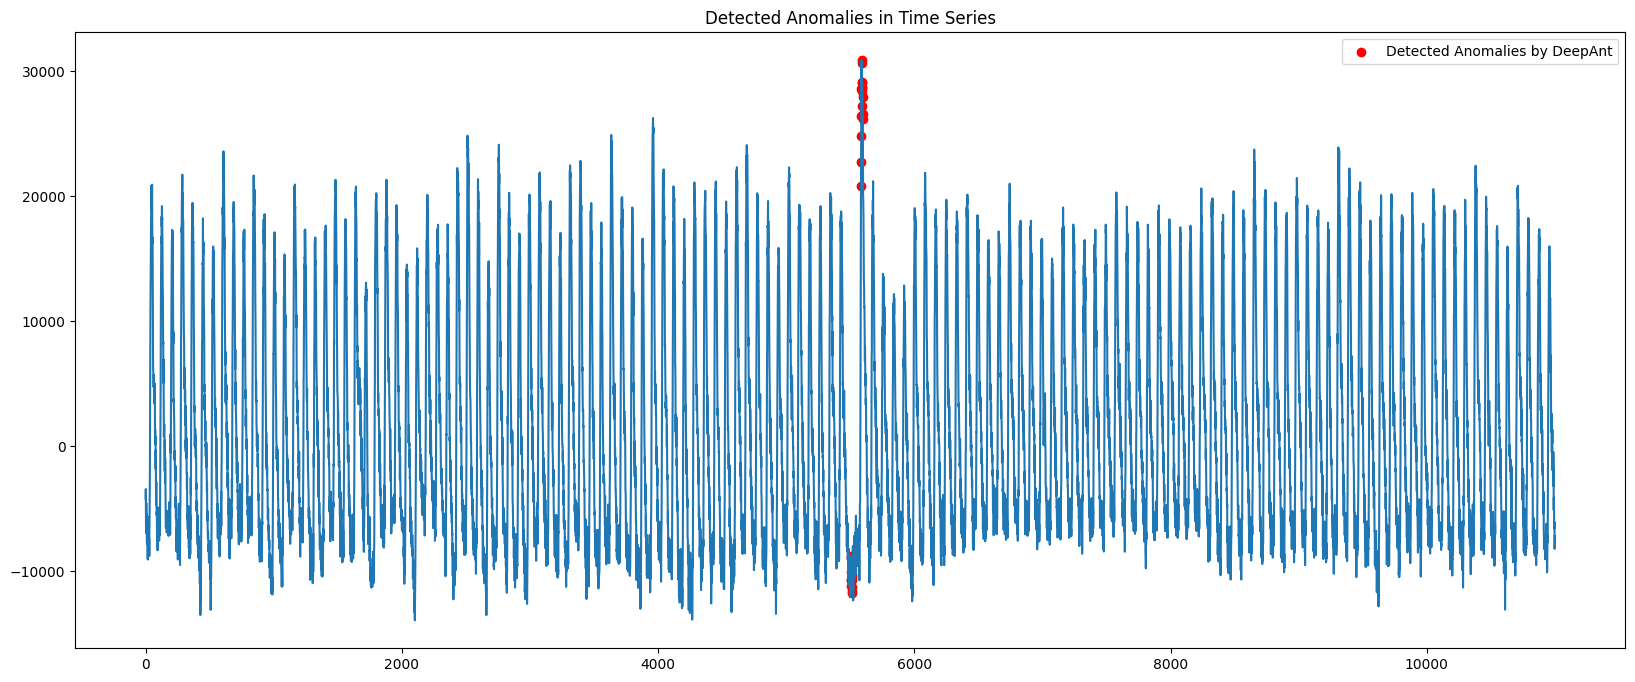

In [14]:
ts_plot(df, preds_losses, THRESHOLD)

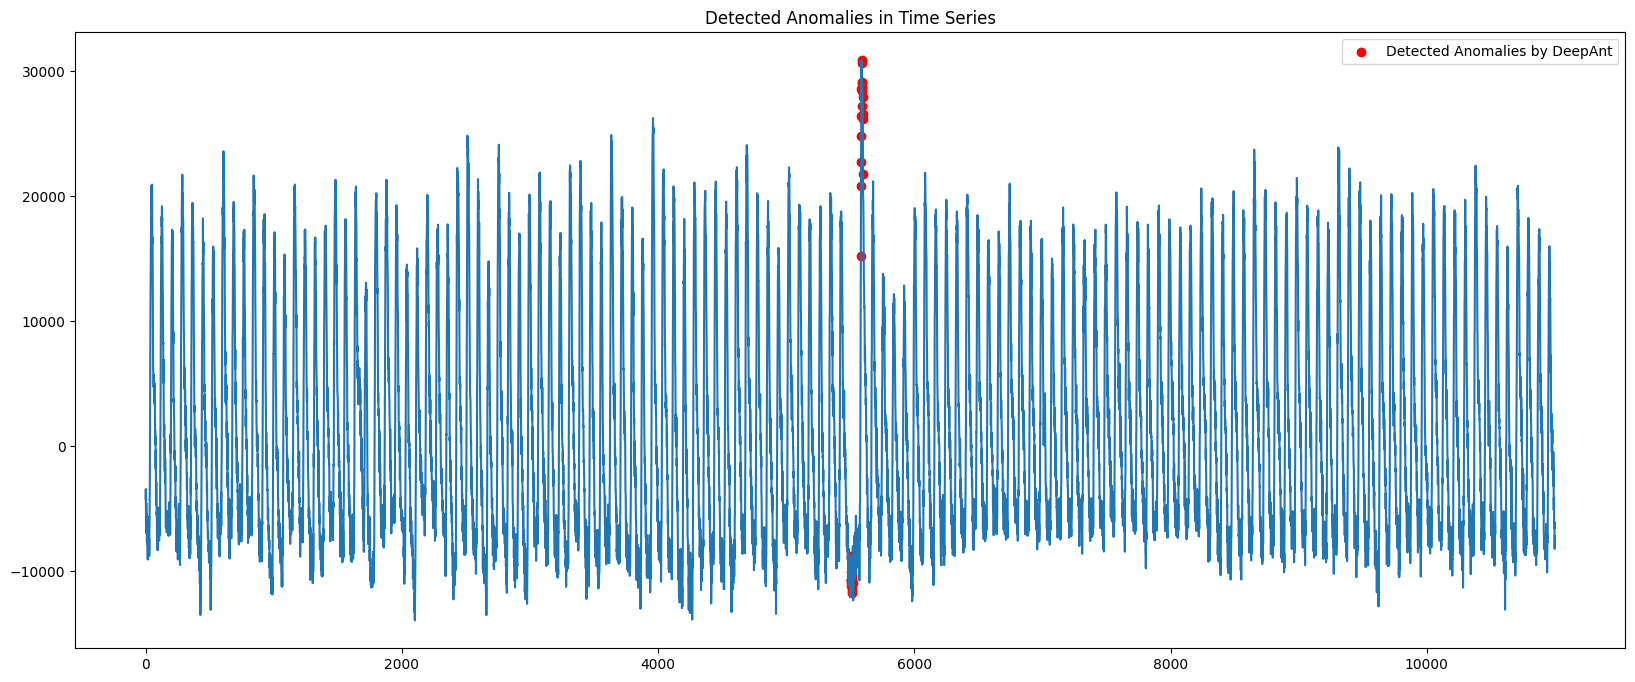

In [43]:
ts_plot(df['value'], preds_losses, THRESHOLD)

In [27]:
y = np.zeros(len(df))

In [29]:
y[5200:5600] =1

In [33]:
len(y)

11000

In [35]:
len(preds_losses)

10836

In [36]:
preds_losses

164      0.018412
165      0.005209
166      0.004458
167      0.045784
168      0.042164
           ...   
10995    0.019191
10996    0.002567
10997    0.000995
10998    0.032840
10999    0.008434
Length: 10836, dtype: float32

In [45]:
preds_losses.index.min()

164

In [46]:
preds_losses.index.max()

10999

In [39]:
df['anomaly'] = y

In [41]:
df['anomaly'].iloc[5400:5600]

5400    1.0
5401    1.0
5402    1.0
5403    1.0
5404    1.0
       ... 
5595    1.0
5596    1.0
5597    1.0
5598    1.0
5599    1.0
Name: anomaly, Length: 200, dtype: float64

In [52]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, RocCurveDisplay

In [51]:
roc_auc_score(df['anomaly'].iloc[preds_losses.index.min():], preds_losses)

0.5495493963204292

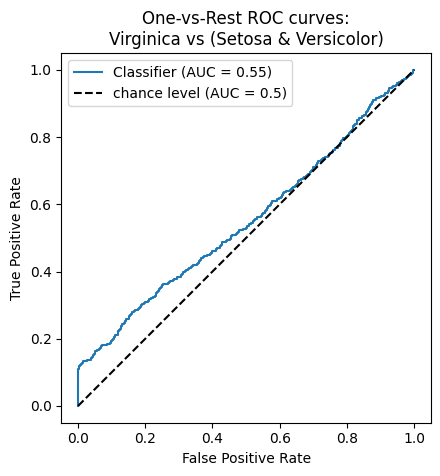

In [88]:
RocCurveDisplay.from_predictions(df['anomaly'].iloc[preds_losses.index.min():], preds_losses)
#plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
#display.plot()

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

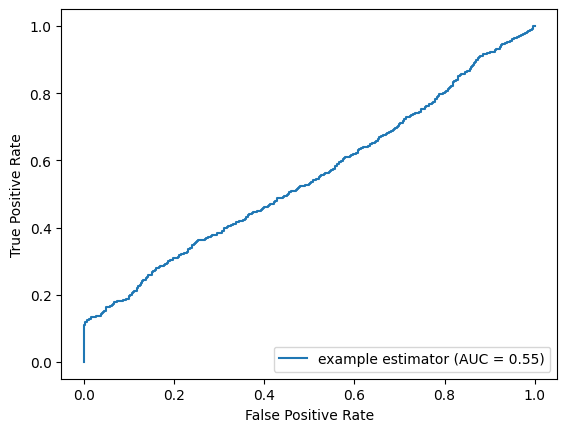

In [79]:
display.plot()